This notebook is a simple example of how to use the `AnnubesEnv` class to create a custom environment and use it to train a reinforcement learning agent with `stable_baselines3`.

## `AnnubesEnv` environment

Let's create an environment, check it works and visualize it.


In [6]:
import neurogym as ngym
from neurogym.envs.annubes import AnnubesEnv
from stable_baselines3.common.env_checker import check_env

env = AnnubesEnv()

# check the custom environment and output additional warnings (if any)
check_env(env)

# check the environment with a random agent
obs, info = env.reset()
n_steps = 10
for _ in range(n_steps):
    # random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        obs, info = env.reset()

print(env.timing)
print("----------------")
print(env.observation_space)
print(env.observation_space.name)
print("----------------")
print(env.action_space)
print(env.action_space.name)

{'fixation': 500, 'stimulus': 1000, 'iti': 0}
----------------
Box(0.0, 1.0, (4,), float32)
{'fixation': 0, 'start': 1, 'v': 2, 'a': 3}
----------------
Discrete(2)
{'fixation': 0, 'choice': [1]}


In [7]:
print(env.observation_space.sample())
model.predict(obs)

[0.3785393  0.3186935  0.5025637  0.64926696]


NameError: name 'model' is not defined

In [8]:
obs, info = env.reset()

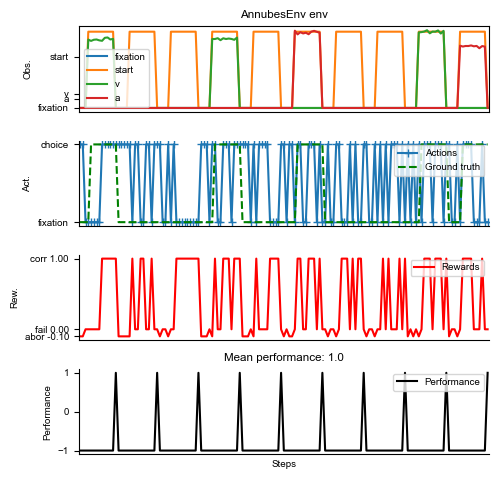

In [9]:
fig = ngym.utils.plot_env(
    env,
    ob_traces=["fixation", "start", "v", "a"],
    num_trials=10
)

## Training `AnnubesEnv`

### 1. Regular training

We can train `AnnubesEnv` using one of the models defined in `stable_baselines3`, for example [`A2C`](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html).


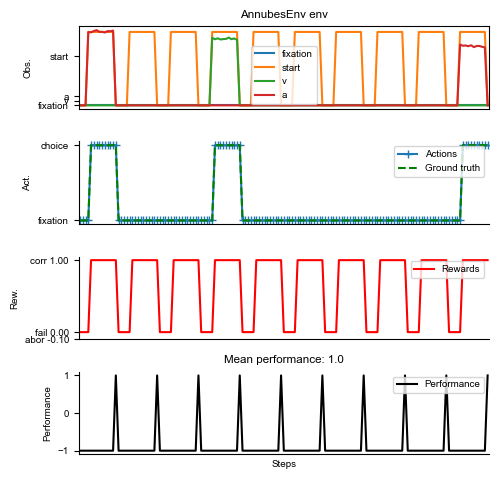

In [10]:
import warnings

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

warnings.filterwarnings("default")

# train agent
env = AnnubesEnv()
env_vec = DummyVecEnv([lambda: env])
model = A2C("MlpPolicy", env_vec, verbose=0)
model.learn(total_timesteps=20000, log_interval=1000)
env_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

# Creating the output for the Psychometric curve

Now we have a model that can perfom given an environment.
For the psychometric curve we need to test the ability of the model, or the performance/ percentage of being correct, depending on different inputs
Thus, What we need to do is creating a range of inputs, and loop over them. for each input we need about 100 trials to get some good statistics
After the loop we need a list of inputs and the percentage of being correct for each input. From this list we can create the psychometric curve by plotting the inputs against the performance.


In [116]:
## 1 - Trial to Create a dictionary for psychometric fucntion
# We Get stuck at obs, info = env.reset()


import numpy as np

def psychometric_dict(env, model, modalities, trials_per_var=11, steps_per_trial=100):
    """
    Runs the model over multiple modalities and trials, collecting performance statistics.

    Parameters:
    - env: The environment where the model runs.
    - model: The trained model.
    - variables: List of modalities (e.g., ["auditory", "visual", "combined"]).
    - trials_per_var: Number of trials per modality.
    - steps_per_trial: Number of steps per trial.

    Returns:
    - results: Nested dictionary with structure:
        {
            "auditory": {
                "trial_1": performance_score,
                "trial_2": performance_score,
                ...
            },
            ...
        }
    """
    results = {var: {} for var in variables}  # Initialize nested dictionary
    stim_intensities = np.linspace(0, 1, 11)
    # print(stim_intensities)

    for mod in modalities:
        for index, stim in enumerate(stim_intensities):  # Loop over trials (trial_1, ..., trial_10)
            # print(mod)
            # print(index)
            # print(stim)

            if mod == "auditory":
                env.session = {"v": 0, "a": 1}
                env.stim_intensities = [stim, stim]

            elif mod == "visual":
                env.session = {"v": 1, "a": 0}
                env.stim_intensities = [stim, stim]
            elif mod == "combined":
                env.session = {"v": 0.5, "a": 0.5}
                env.stim_intensities = [stim, stim]

            obs, info = env.reset()

            # try:
            #     obs, info = env.reset()
            #     print("reset worked")
            # except ValueError as e:
            #     print(f"Error resetting env for {mod}, trial {index+1}: {e}")
            #     continue

            correct_actions = 0  # Track correct actions
            stim_trials = 0

            for _ in range(steps_per_trial):
                # print(obs)
                action, _ = model.predict(obs)  # Get action from model
                # print('-------------')
                # print(f'mod: {mod}')
                # print(f'stim_intensities: {stim}')
                # print(f'action: {action}')
                obs, reward, terminated, truncated, info = env.step(action)  # Execute action
                # print(f'obs: {obs}')
                # print(f'info:', info)
                # print(f'reward:', reward)

                if obs[2] > 0 or obs[3] > 0:
                    stim_trials += 1

                if action == 1 and info['gt']:
                    correct_actions += 1

                if terminated:  # Stop trial if it ends early
                    break
            stim_percentage = (stim_trials / steps_per_trial) * 100
            # print(f"stim_percentage: {stim_percentage}")

            # Compute percentage of correct actions
            try:
                performance_score = (correct_actions / stim_trials) * 100
            except ZeroDivisionError:
                performance_score = 0

            # print(f"Performance Score: {type(performance_score)}")
            results[mod][stim] = performance_score  # Store result

    return results
    # print(results)


In [129]:
# Plot the psychometric function

import matplotlib.pyplot as plt
import numpy as np

def plot_psychometric_curve(performance_results):
    """
    Plots the psychometric curve for each modality in the experiment.

    Parameters:
    - performance_results: A nested dictionary with performance data.

    Output:
    - A plot showing how performance changes with stimulus intensity.
    """
    # Define the stimulus intensities (correspond to the 11 trials)
    stim_intensities = list(performance_results["auditory"].keys())
    # stim_intensities = np.arange(0, 1.1, 0.1)  # [0, 0.1, 0.2, ..., 1.0]

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Loop over each modality (auditory, visual, combined)
    for modality, trials in performance_results.items():
        print(f"Modality: {modality}")
        print(f"Trials: {trials}")
        # Extract performance values in order
        y_values = [trials[stim] for stim in stim_intensities]

        # Plot the curve
        plt.plot(stim_intensities, y_values, marker="o", linestyle="-", label=modality)

    # Label axes and title
    plt.xlabel("Stimulus Intensity")
    plt.ylabel("Correct Responses (%)")
    plt.title("Psychometric Curve")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


dict_items([('auditory', {np.float64(0.0): 0.0, np.float64(0.1): 0.0, np.float64(0.2): 0.0, np.float64(0.30000000000000004): 3.3333333333333335, np.float64(0.4): 40.0, np.float64(0.5): 94.11764705882352, np.float64(0.6000000000000001): 97.2972972972973, np.float64(0.7000000000000001): 96.29629629629629, np.float64(0.8): 94.11764705882352, np.float64(0.9): 100.0, np.float64(1.0): 100.0}), ('visual', {np.float64(0.0): 0.0, np.float64(0.1): 0.0, np.float64(0.2): 0.0, np.float64(0.30000000000000004): 2.7027027027027026, np.float64(0.4): 40.74074074074074, np.float64(0.5): 91.8918918918919, np.float64(0.6000000000000001): 96.29629629629629, np.float64(0.7000000000000001): 100.0, np.float64(0.8): 97.2972972972973, np.float64(0.9): 97.2972972972973, np.float64(1.0): 100.0}), ('combined', {np.float64(0.0): 0.0, np.float64(0.1): 0.0, np.float64(0.2): 0.0, np.float64(0.30000000000000004): 3.7037037037037033, np.float64(0.4): 45.94594594594595, np.float64(0.5): 98.0, np.float64(0.6000000000000001

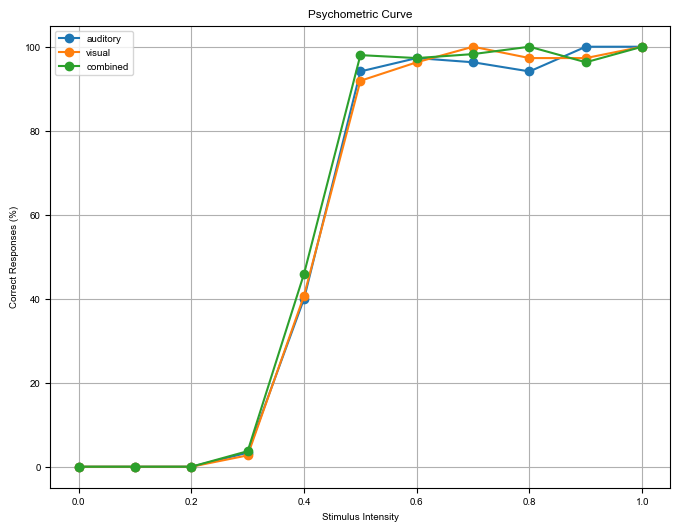

In [131]:
modalities = ["auditory", "visual", "combined"]

# Run model trials and collect performance data
performance_results = psychometric_dict(env, model, modalities)
# print(performance_results)
# print(performance_results['auditory'])
# print(list(performance_results['auditory'].keys()))

print(performance_results.items())

# Plot the psychometric curve
plot_psychometric_curve(performance_results)

### 2. Sequential training

We can also train `AnnubesEnv` using a sequential training approach. This is useful when we want to train the agent in multiple stages, each with a different environment configuration. This can be useful for:

- **Curriculum learning**: Gradually increase the difficulty of the environments. Start with simpler tasks and progressively move to more complex ones, allowing the agent to build on its previous experiences.

- **Domain randomization**: Vary the environment dynamics (e.g., physics, obstacles) during training to improve the agent's robustness to changes in the environment.

- **Transfer learning**: If you have access to different agents or architectures, you can use transfer learning techniques to fine-tune the model on a new environment.

In this case it is important to include all the possible observations in each environment, even if not all of them are used. This is because the model is initialized with the first environment's observation space and it is not possible to change it later.


In [ ]:
env1 = AnnubesEnv({"v": 1, "a": 0})
env1_vec = DummyVecEnv([lambda: env1])
# create a model and train it with the first environment
model = A2C("MlpPolicy", env1_vec, verbose=0)
model.learn(total_timesteps=10000)
env1_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env1, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

In [ ]:
# switch to the second environment and continue training
env2 = AnnubesEnv({"v": 0, "a": 1})
env2_vec = DummyVecEnv([lambda: env2])
# set the model's environment to the new environment
model.set_env(env2_vec)
model.learn(total_timesteps=10000)
env2_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env2, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

In [ ]:
# Switch to the third environment and finish training
env3 = AnnubesEnv({"v": 0.5, "a": 0.5})
env3_vec = DummyVecEnv([lambda: env3])
# set the model's environment to the new environment
model.set_env(env3_vec)
model.learn(total_timesteps=20000)
env3_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env3, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

In [ ]:
# Save the final model after all training
model.save("final_model")